# Final Project -- Deep Learning for Named Entity Recognition
# Author: Ruoyan Kong
# Date: 04/20/2019

# 1. Overview
## Goals:
This notebook's goal is to use Bidirectional LSTM + CNN model to solve the name entity recogonition problem (tagging entities in text with their corresponding type). We use the Reuters News Corpus Dataset to test our model.

Here are helpful refernces (the dataset is updated so our result is different from the reference):

https://towardsdatascience.com/deep-learning-for-named-entity-recognition-2-implementing-the-state-of-the-art-bidirectional-lstm-4603491087f1

https://github.com/mxhofer/Named-Entity-Recognition-BidirectionalLSTM-CNN-CoNLL

## Problems -- Language-Independent Named Entity Recognition Task (NER):
Named entity recognition (NER) is the task of tagging entities in text with their corresponding type. Approaches typically use BIO notation, which differentiates the beginning (B) and the inside (I) of entities. O is used for non-entity tokens.

This notebook shows the data analysis process, the model building, and the performance analysis.

## Models -- BLSTM, LSTM (baseline model):
Long short-term memory (LSTM) cells are the building block of recurrent neural networks (RNNs). While plain LSTM cells in a feedforward neural network process text just like humans do (from left to right), BLSTMs also consider the opposite direction. This allows the model to uncover more patterns as the amount of input information is increased. In other words, the model not only considers the sequence of tokens after a token of interest, but also before the token of interest.

### Why is BLSTM+CNN suitable for NER problem?
BLSTM+CNN learns both character- and word-level features, uses context with a flexible window
around each word – an approach that utilize useful long-distance relations between words. Exploiting explicit character level features such as prefix and suffix could be useful especially with rare words where word embeddings are poorly trained.


# 2. Data
## CoNLL-2003 named entity data
from paper: Introduction to the CoNLL-2003 Shared Task: Language-Independent Named Entity Recognition

The CoNLL-2003 named entity data consists of eight files covering two languages: English and German

1. For each of the languages there is a training file, a development file, a test file and a large file with unannotated data. The English data was taken from the Reuters Corpus

2. This corpus consists of Reuters news stories between August 1996 and August 1997. For the training and development set, ten days’ worth of data were taken from the files representing the end of August 1996. For the test set, the texts were from December 1996. The preprocessed raw data covers the month of September 1996.

Here are the official CoNLL 2003 introduction paper https://www.aclweb.org/anthology/W03-0419.

To build the English-language corpus we need the RCV1 Reuters corpus (You will obtain access a couple days after submitting the organisational and individual agreement at no charge) https://trec.nist.gov/data/reuters/reuters.html.

## Data Processing

In [2]:
"""Packages"""
import pydot
import numpy as np
from keras.models import Model, load_model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate
from keras.utils import plot_model
from keras.initializers import RandomUniform
from keras.optimizers import SGD, Nadam
import random
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Data Format
Entities are annotated with LOC (location), ORG (organisation), PER (person) and MISC (miscellaneous). 

The data files contain one word per line. Empty lines have been used
for marking sentence boundaries and a line containing the keyword
-DOCSTART- has been added to the beginning of each article in order
to mark article boundaries. Each non-empty line contains the following 
tokens:

   1. the current word
   2. the part-of-speech (POS) tag generated by a tagger
   3. the chunk tag generated by a text chunker
   4. the named entity tag given by human annotators
   
The tagger and chunker for English are roughly similar to the 
ones used in the memory-based shallow parser demo available at 
http://ilk.uvt.nl/

The chunk tags and the named entity tags use the IOB1 format. This 
means that in general words inside entity receive the tag I-TYPE
to denote that they are Inside an entity of type TYPE. Whenever
two entities of the same type immediately follow each other, the 
first word of the second entity will receive tag B-TYPE rather than
I-TYPE in order to show that a new entity starts at that word.

In [3]:
trainfilename = './data/eng.train'
testafilename = './data/eng.testa'
testbfilename = './data/eng.testb'
with open(trainfilename) as myfile:
    head = [next(myfile) for x in range(20)]
print("[word] [POS tag] [chunk tag] [NER tag]")
for line in head:
    print(line)
    

[word] [POS tag] [chunk tag] [NER tag]
-DOCSTART- -X- O O



EU NNP I-NP I-ORG

rejects VBZ I-VP O

German JJ I-NP I-MISC

call NN I-NP O

to TO I-VP O

boycott VB I-VP O

British JJ I-NP I-MISC

lamb NN I-NP O

. . O O



Peter NNP I-NP I-PER

Blackburn NNP I-NP I-PER



BRUSSELS NNP I-NP I-LOC

1996-08-22 CD I-NP O



The DT I-NP O

European NNP I-NP I-ORG



For example, in "EU rejects German call to boycott British lamb" we have 3 entities, EU is organization, German and British is miscellaneous.

We build a CNN_BLSTM class to build the data strucuture of the NER problem.

In [4]:
class CNN_BLSTM(object):
    def readfile(self, filename):
        '''
        read file
        return format :
        [ ['EU', 'B-ORG'], ['rejects', 'O'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O'] ]
        '''
        stat = {"Article_n":0, "Sentence_n":0, "Token_n":0, "Article_Sentence_n": [], "Article_Word_n": [], "Sentence_Word_n": []}
        f = open(filename)
        sentences = []
        sentence = []
        ASN = -1
        AWN = 0
        SWN = 0
        for line in f:
            if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
                if line.startswith('-DOCSTART'):
                    stat["Article_n"] += 1
                    if ASN == -1:
                        ASN = 0
                    else:
                        stat["Article_Sentence_n"].append(ASN)
                        stat["Article_Word_n"].append(AWN)
                        ASN = 0
                        AWN = 0
                if len(sentence) > 0:
                    ASN += 1
                    AWN += len(sentence)
                    stat["Sentence_Word_n"].append(len(sentence))
                    sentences.append(sentence)
                    stat["Sentence_n"] += 1
                    stat["Token_n"] += len(sentence)
                    sentence = []
                continue
            splits = line.split(' ')
            sentence.append([splits[0], splits[-1]])

        if len(sentence) > 0:
            sentences.append(sentence)
            sentence = []
        return sentences, stat
    
    def loadData(self):
        self.trainSentences, self.trainSentences_stat = self.readfile(trainfilename)
        self.devSentences, self.devSentences_stat = self.readfile(testafilename)
        self.testSentences, self.testSentences_stat = self.readfile(testbfilename)

In [5]:
self = CNN_BLSTM()
self.loadData()

Now each element of the sentences set is [word, entity] for all words in a sentence:

In [6]:
for line in self.trainSentences[:2]:
    print(line)

[['EU', 'I-ORG\n'], ['rejects', 'O\n'], ['German', 'I-MISC\n'], ['call', 'O\n'], ['to', 'O\n'], ['boycott', 'O\n'], ['British', 'I-MISC\n'], ['lamb', 'O\n'], ['.', 'O\n']]
[['Peter', 'I-PER\n'], ['Blackburn', 'I-PER\n']]


# 3. Exploratory Data Analysis 
## size of dataset
In the trainset, we have 946 articles, 14041 sentences, 203621 words. In the development set, we have 216 articles, 3250 sentences, 51362 words. In the testset, we have 231 articles, 3453 sentences, 46435 words.

In [7]:
print('Size of trainset')
print({x: self.trainSentences_stat[x] for x in ["Article_n","Sentence_n","Token_n"]})
print('Size of developmentset')
print({x: self.devSentences_stat[x] for x in ["Article_n","Sentence_n","Token_n"]})
print('Size of testset')
print({x: self.testSentences_stat[x] for x in ["Article_n","Sentence_n","Token_n"]})


Size of trainset
{'Article_n': 946, 'Sentence_n': 14041, 'Token_n': 203621}
Size of developmentset
{'Article_n': 216, 'Sentence_n': 3250, 'Token_n': 51362}
Size of testset
{'Article_n': 231, 'Sentence_n': 3453, 'Token_n': 46435}


## number of entities

In [8]:
def entity_stat(self):
    result = []
    for sentences in [self.trainSentences, self.devSentences, self.testSentences]:
        entity_stat = {"LOC":0, "MIS":0, "ORG":0, "PER":0}
        for sentence in sentences:
            i = 0
            while (i<len(sentence)):
                entity = sentence[i][1]
                if entity[2:5] in entity_stat:
                    entity_stat[entity[2:5]] += 1
                    while i<len(sentence) and entity[2:5] in entity_stat:
                        entity = sentence[i][1]
                        i += 1
                    i -= 1
                i += 1
        result.append(entity_stat)
    for res, stat in zip(result,[self.trainSentences_stat, self.devSentences_stat, self.testSentences_stat]):
        stat['entity'] = res
CNN_BLSTM.entity_stat = entity_stat

In [9]:
self.entity_stat()
print('# of entities in trainset')
print(self.trainSentences_stat['entity'])
print('# of entities in developmentset')
print(self.devSentences_stat['entity'])
print('# of entities in testset')
print(self.testSentences_stat['entity'])

# of entities in trainset
{'LOC': 7114, 'MIS': 3363, 'ORG': 6247, 'PER': 6532}
# of entities in developmentset
{'LOC': 1832, 'MIS': 912, 'ORG': 1325, 'PER': 1829}
# of entities in testset
{'LOC': 1658, 'MIS': 689, 'ORG': 1649, 'PER': 1597}


## Number of Sentences per Article (Trainset)
From the figure we could see that most articles have less than 50 sentences.

/home/ruoyan/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


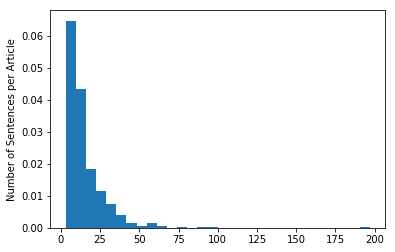

In [10]:

plt.hist(self.trainSentences_stat["Article_Sentence_n"], normed=True, bins=30)
plt.ylabel('Number of Sentences per Article');

## Number of Words per Article (Trainset)
From the figure we could see that most articles have less than 400 words.

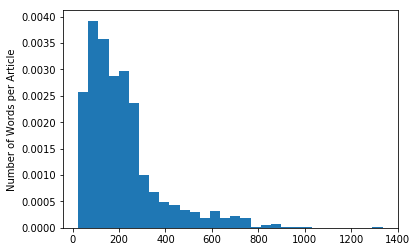

In [11]:
plt.hist(self.trainSentences_stat["Article_Word_n"], normed=True, bins=30)
plt.ylabel('Number of Words per Article');

## Number of Words per Sentence (Trainset)
From the figure we could see that most sentences have less than 40 words.

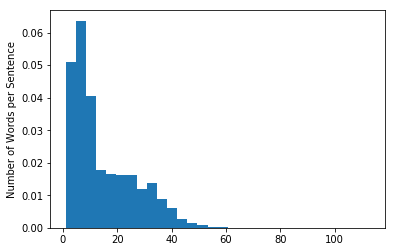

In [12]:
plt.hist(self.trainSentences_stat["Sentence_Word_n"], normed=True, bins=30)
plt.ylabel('Number of Words per Sentence');

## Data preprocessing

In [13]:
"""Set parameters"""

self.EPOCHS = 30               # paper: 80
self.DROPOUT = 0.5             # paper: 0.68
self.DROPOUT_RECURRENT = 0.25  # not specified in paper, 0.25 recommended
self.LSTM_STATE_SIZE = 200     # paper: 275
self.CONV_SIZE = 3             # paper: 3
self.LEARNING_RATE = 0.0105    # paper 0.0105
self.OPTIMIZER = Nadam()       # paper uses SGD(lr=self.learning_rate), Nadam() recommended

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
# returns data with character information in format
# [['EU', ['E', 'U'], 'B-ORG\n'], ...]
def addCharInformation(Sentences):
    for i, sentence in enumerate(Sentences):
        for j, data in enumerate(sentence):
            chars = [c for c in data[0]]
            Sentences[i][j] = [data[0], chars, data[1]]
    return Sentences

def addCharInfo(self):
    # format: [['EU', ['E', 'U'], 'B-ORG\n'], ...]
    self.trainSentences = addCharInformation(self.trainSentences)
    self.devSentences = addCharInformation(self.devSentences)
    self.testSentences = addCharInformation(self.testSentences)
CNN_BLSTM.addCharInfo = addCharInfo

In [15]:
self.addCharInfo()

Now each element of the sentences set is [word,word_chars, entity] for all words in a sentence:

In [16]:
for line in self.trainSentences[:2]:
    print(line)

[['EU', ['E', 'U'], 'I-ORG\n'], ['rejects', ['r', 'e', 'j', 'e', 'c', 't', 's'], 'O\n'], ['German', ['G', 'e', 'r', 'm', 'a', 'n'], 'I-MISC\n'], ['call', ['c', 'a', 'l', 'l'], 'O\n'], ['to', ['t', 'o'], 'O\n'], ['boycott', ['b', 'o', 'y', 'c', 'o', 't', 't'], 'O\n'], ['British', ['B', 'r', 'i', 't', 'i', 's', 'h'], 'I-MISC\n'], ['lamb', ['l', 'a', 'm', 'b'], 'O\n'], ['.', ['.'], 'O\n']]
[['Peter', ['P', 'e', 't', 'e', 'r'], 'I-PER\n'], ['Blackburn', ['B', 'l', 'a', 'c', 'k', 'b', 'u', 'r', 'n'], 'I-PER\n']]


Now we create word- and character-level embeddings to project sentence features into numbers.

In [17]:
# define casing s.t. NN can use case information to learn patterns
def getCasing(word, caseLookup):
    casing = 'other'

    numDigits = 0
    for char in word:
        if char.isdigit():
            numDigits += 1

    digitFraction = numDigits / float(len(word))

    if word.isdigit():  # Is a digit
        casing = 'numeric'
    elif digitFraction > 0.5:
        casing = 'mainly_numeric'
    elif word.islower():  # All lower case
        casing = 'allLower'
    elif word.isupper():  # All upper case
        casing = 'allUpper'
    elif word[0].isupper():  # is a title, initial char upper, then all lower
        casing = 'initialUpper'
    elif numDigits > 0:
        casing = 'contains_digit'

    return caseLookup[casing]

def createMatrices(sentences, word2Idx, label2Idx, case2Idx, char2Idx):
    unknownIdx = word2Idx['UNKNOWN_TOKEN']
    paddingIdx = word2Idx['PADDING_TOKEN']

    dataset = []

    wordCount = 0
    unknownWordCount = 0

    for sentence in sentences:
        wordIndices = []
        caseIndices = []
        charIndices = []
        labelIndices = []

        for word, char, label in sentence:
            wordCount += 1
            if word in word2Idx:
                wordIdx = word2Idx[word]
            elif word.lower() in word2Idx:
                wordIdx = word2Idx[word.lower()]
            else:
                wordIdx = unknownIdx
                unknownWordCount += 1
            charIdx = []
            for x in char:
                charIdx.append(char2Idx[x])
            # Get the label and map to int
            wordIndices.append(wordIdx)
            caseIndices.append(getCasing(word, case2Idx))
            charIndices.append(charIdx)
            labelIndices.append(label2Idx[label])

        dataset.append([wordIndices, caseIndices, charIndices, labelIndices])

    return dataset

# 0-pads all words
def padding(Sentences):
    maxlen = 52
    for sentence in Sentences:
        char = sentence[2]
        for x in char:
            maxlen = max(maxlen, len(x))
    for i, sentence in enumerate(Sentences):
        Sentences[i][2] = pad_sequences(Sentences[i][2], 52, padding='post')
    return Sentences

def embed(self):
    """Create word- and character-level embeddings"""

    labelSet = set()
    words = {}

    # unique words and labels in data  
    for dataset in [self.trainSentences, self.devSentences, self.testSentences]:
        for sentence in dataset:
            for token, char, label in sentence:
                # token ... token, char ... list of chars, label ... BIO labels   
                labelSet.add(label)
                words[token.lower()] = True

    # mapping for labels
    self.label2Idx = {}
    for label in labelSet:
        self.label2Idx[label] = len(self.label2Idx)

    # mapping for token cases
    case2Idx = {'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5,
                'contains_digit': 6, 'PADDING_TOKEN': 7}
    self.caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

    # read GLoVE word embeddings
    word2Idx = {}
    self.wordEmbeddings = []

    fEmbeddings = open("embeddings/glove.6B.50d.txt", encoding="utf-8")

    # loop through each word in embeddings
    for line in fEmbeddings:
        split = line.strip().split(" ")
        word = split[0]  # embedding word entry

        if len(word2Idx) == 0:  # add padding+unknown
            word2Idx["PADDING_TOKEN"] = len(word2Idx)
            vector = np.zeros(len(split) - 1)  # zero vector for 'PADDING' word
            self.wordEmbeddings.append(vector)

            word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
            vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
            self.wordEmbeddings.append(vector)

        if split[0].lower() in words:
            vector = np.array([float(num) for num in split[1:]])
            self.wordEmbeddings.append(vector)  # word embedding vector
            word2Idx[split[0]] = len(word2Idx)  # corresponding word dict

    self.wordEmbeddings = np.array(self.wordEmbeddings)

    # dictionary of all possible characters
    self.char2Idx = {"PADDING": 0, "UNKNOWN": 1}
    for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
        self.char2Idx[c] = len(self.char2Idx)

    # format: [[wordindices], [caseindices], [padded word indices], [label indices]]
    self.train_set = padding(createMatrices(self.trainSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
    self.dev_set = padding(createMatrices(self.devSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
    self.test_set = padding(createMatrices(self.testSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))

    self.idx2Label = {v: k for k, v in self.label2Idx.items()}
CNN_BLSTM.embed = embed

In [18]:
self.embed()

The dataset now becomes numerical, which then can be dealt with by neural network.

In [19]:
for line in self.train_set[:2]:
    print(line)

[[641, 6732, 512, 578, 6, 4940, 295, 8353, 4], [2, 1, 3, 1, 1, 1, 3, 1, 4], array([[43, 59,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [30, 17, 22, 17, 15, 32, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [45, 17, 30, 25, 13, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [15, 13, 24, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  

Now we create batches.

In [20]:
def _createBatches(data):
    l = []
    for i in data:
        l.append(len(i[0]))
    l = set(l)
    batches = []
    batch_len = []
    z = 0
    for i in l:
        for batch in data:
            if len(batch[0]) == i:
                batches.append(batch)
                z += 1
        batch_len.append(z)
    return batches,batch_len

def createBatches(self):
    """Create batches"""
    self.train_batch, self.train_batch_len = _createBatches(self.train_set)
    self.dev_batch, self.dev_batch_len = _createBatches(self.dev_set)
    self.test_batch, self.test_batch_len = _createBatches(self.test_set)
    
CNN_BLSTM.createBatches = createBatches

In [21]:
self.createBatches()
print('length of trainset batch')
print(self.train_batch_len)
print('length of deveopmentset batch')
print(self.dev_batch_len)
print('length of trestset batch')
print(self.test_batch_len)

length of trainset batch
[179, 1308, 1894, 2665, 3416, 4041, 4945, 6001, 6895, 7398, 7805, 8129, 8483, 8776, 9055, 9290, 9523, 9721, 9916, 10130, 10343, 10560, 10770, 10991, 11214, 11426, 11628, 11845, 12061, 12255, 12464, 12650, 12823, 12978, 13113, 13237, 13339, 13437, 13546, 13626, 13698, 13762, 13814, 13859, 13899, 13926, 13947, 13965, 13978, 13993, 14003, 14014, 14017, 14021, 14026, 14027, 14030, 14032, 14034, 14036, 14038, 14039, 14040, 14041]
length of deveopmentset batch
[15, 280, 376, 549, 679, 811, 1113, 1337, 1467, 1590, 1694, 1777, 1834, 1896, 1937, 1990, 2036, 2092, 2148, 2215, 2286, 2343, 2389, 2438, 2486, 2531, 2586, 2640, 2699, 2757, 2801, 2849, 2887, 2931, 2966, 3013, 3053, 3074, 3098, 3119, 3139, 3157, 3175, 3191, 3202, 3211, 3213, 3215, 3221, 3223, 3226, 3231, 3233, 3234, 3237, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250]
length of trestset batch
[33, 310, 474, 686, 874, 1051, 1387, 1714, 1937, 2064, 2144, 2207, 2261, 2316, 2374, 2416, 2468, 2518, 2564

In [22]:
print(self.train_batch[:2])

[[[4], [4], array([[65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), [0]], [[15954], [2], array([[58, 46, 39, 61, 56, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), [3]]]


# 4.Model
We build Bidirectional LSTMs + CNN in this section.
The figure below shows the BLSTM. x stands for the input sequence, h for the output sequence from forward or backward runs (defined by the arrow pointing right or left, respectively), y for the concatenated output sequence where sigma concatenates the forward and backward output elements.

<img src="https://cdn-images-1.medium.com/max/800/1*QBrVVvYps5zo6QtBRRq4fA.png">

## Embeddings
After loading the training, development and testing data files, the embed function creates word- and character-level embeddings. This means that words and characters are mapped to real numbers that the neural network can work with. More specifically, labels (e.g. B-ORG, I-ORG, B-LOC, etc.), token cases (e.g. lower case, upper case or numeric tokens) and characters are mapped to a real number using a dictionary data structure. Furthermore, all unique words are mapped to GloVE embedding vectors.

## Model architecture
The BLSTM layer forms the core of the network and has the following three inputs:

Character-level patters are identified by a convolutional neural network
Word-level input from GloVE embeddings
Casing input (whether words are lower case, upper case, etc.)
The graph below shows the model architecture with all layers. A softmax activation layer generates the final outputs.

<img src="https://cdn-images-1.medium.com/max/800/1*IZSxs-rwglEWALLBDRfTzw.png">

## Set Parameters
We use the recommended parameter in the paper https://arxiv.org/pdf/1511.08308.pdf which claimed can reach a F1 > 0.9, except epochs (which was 80). We use 30 epochs due to limited time.

In [23]:
EPOCHS = 30    # Number of Training Epochs           
DROPOUT = 0.5  # inputs dropout ratio           
DROPOUT_RECURRENT = 0.25 # dropout ratio in RNN
LSTM_STATE_SIZE = 200   # LSTM has 200 states
CONV_SIZE = 3   # size of CNN layer      
LEARNING_RATE = 0.0105    # optimization learning ratio
OPTIMIZER = Nadam()       # use nadam optimizer (Adam RMSprop with Nesterov momentum)

self.epochs = EPOCHS
self.dropout = DROPOUT
self.dropout_recurrent = DROPOUT_RECURRENT
self.lstm_state_size = LSTM_STATE_SIZE
self.conv_size = CONV_SIZE
self.learning_rate = LEARNING_RATE
self.optimizer = OPTIMIZER

## Build Character Input
For each word we employ a convolution and a max layer to extract a new feature vector from the percharacter feature vectors such as character embeddings. Words are padded with a number of special PADDING characters on both sides depending on the window size of the CNN. The hyper-parameters of the CNN are the window size and the output vector size.

We randomly initialized a lookup table with values drawn from a uniform distribution with range [−0.5, 0.5] to output a character embedding of 30 dimensions. The character set includes all unique characters in the CoNLL-2003 dataset8 plus the special tokens PADDING and UNKNOWN. The PADDING token is used for the CNN, and the UNKNOWN token is used for all other characters.

Character embedding
layer maps
a vocabulary of 97 possible
characters to 30-dimensional
embedding, initialized randomly
from U(−0.5,0.5). The number of
input samples per batch and the number of words
per sample (‘w’) vary from batch to
batch. The maximum number of
characters per word (‘c’) was 52.

In [24]:
# character input
character_input = Input(shape=(None, 52,), name="Character_input")
embed_char_out = TimeDistributed(
    Embedding(len(self.char2Idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="Character_embedding")(
    character_input)
# drop rate 0.5 are applied to the character-level input to mitigate the risk of overfitting. 
dropout = Dropout(self.dropout)(embed_char_out)
dropout.get_shape()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


TensorShape([Dimension(None), Dimension(None), Dimension(52), Dimension(30)])

The input has 52 components, the output has 30 components.Dropout consists in randomly setting a fraction rate 0.5 of input units to 0 at each update during training time, which helps prevent overfitting. The units that are kept are scaled by 2, so that their sum is unchanged at training time and inference time.

## Build CNN
Then we use a cnn layer and a maxpool layer to generate the character input for BLSTM. A dropout level is added to prevent overfitting.Conv1D processes
the 1-dimensional character input with 30
kernels of width 3. This layer is followed by a
1d maxpool operation (char_maxpool) of
window size 52 and stride of 52, which
effectively compiles the character dimension
into size 1. The kernel is initialized by drawing
from a Glorot uniform distribution.

In [25]:
# CNN
conv1d_out = TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(52), name="Maxpool")(conv1d_out)
char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
char = Dropout(self.dropout)(char)
char

<tf.Tensor 'dropout_2/cond/Merge:0' shape=(?, ?, 30) dtype=float32>

The layer has 30 components. We build the layer dealing with the word-level input next. Word embedding layer (words_input) maps a
vocabulary of ‘Vw’ words into 50-dimensional
embeddings. Unless stated otherwise, we use
the GloVE Wikipedia 2014 and Gigaword 5
embeddings with 6B tokens.

In [26]:
# word-level input
words_input = Input(shape=(None,), dtype='int32', name='words_input')
words = Embedding(input_dim=self.wordEmbeddings.shape[0], output_dim=self.wordEmbeddings.shape[1], weights=[self.wordEmbeddings],
                  trainable=False)(words_input)
words

<tf.Tensor 'embedding_2/embedding_lookup/Identity:0' shape=(?, ?, 50) dtype=float32>

The layer has 50 components. The last input layer to build is the case level input (whether words are lower case, upper case). Casing embedding layer (casing_input) maps
a vocabulary of ‘Vca’ casing types into Vca dimensional embeddings. By default, 8 casing
types are considered: numeric, allLower,
allUpper, mainly_numeric (more than 50% of
characters of a word are numeric), initialUpper,
contains_digit, padding and other (if no
category was applicable).

In [27]:
# case-info input
casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
casing = Embedding(output_dim=self.caseEmbeddings.shape[1], input_dim=self.caseEmbeddings.shape[0], weights=[self.caseEmbeddings],
                   trainable=False)(casing_input)
casing

<tf.Tensor 'embedding_3/embedding_lookup/Identity:0' shape=(?, ?, 8) dtype=float32>

It has 8 components. Then we build a concatenate layer to take the input from characters, words, and cases. Concatenation layer (merge_concatenate)
combines processed character-level (a vector
of 30 dimensions per sample input), word-level
(50 dimensions) and casing (Vca dimensions)
data into a vector of 80 + Vca dimensions.

In [28]:
output_ = concatenate([words, casing, char])
output_

<tf.Tensor 'concatenate_1/concat:0' shape=(?, ?, 88) dtype=float32>

The layer has 30+50+8 = 88 components. Then a Bidirectional LSTM is added to uncover more patterns of the inputs (considers the sequence of tokens before/after a token of interest). A softmax layer is added to generate the probability distribution. Bidirectional LSTM (BLSTM) (Schuster &
Paliwal, 1997) layer (merge_BLSTM)
transforms the previously concatenated data
into two vectors of 200 units, one applying
forwards and another backwards recursion on
the input The kernels are initialized by drawing
from a Glorot uniform distribution (Glorot &
Bengio, 2010). Bias terms are initialized to
zero. 

Dense output layer (merge_softmax) applies
a layer-wise softmax function to output a
prediction for locating and classifying
sequences of words in the input text. The
number of units depends on the specific
objective task. The kernel is initialized by
drawing from a Glorot uniform distribution
(Glorot & Bengio, 2010). Bias terms are
initialized to zero.

In [29]:
output = Bidirectional(LSTM(self.lstm_state_size, 
                            return_sequences=True, 
                            dropout=self.dropout,                        # on input to each LSTM block
                            recurrent_dropout=self.dropout_recurrent     # on recurrent input signal
                           ), name="BLSTM")(output_)
output = TimeDistributed(Dense(len(self.label2Idx), activation='softmax'),name="Softmax_layer")(output)
output

<tf.Tensor 'Softmax_layer/Reshape_1:0' shape=(?, ?, 8) dtype=float32>

In [30]:
outputLSTM = LSTM(self.lstm_state_size, 
                            return_sequences=True, 
                            dropout=self.dropout,                        # on input to each LSTM block
                            recurrent_dropout=self.dropout_recurrent     # on recurrent input signal
                           , name="LSTM")(output_)
outputLSTM = TimeDistributed(Dense(len(self.label2Idx), activation='softmax'),name="Softmax_layer2")(outputLSTM)
outputLSTM

<tf.Tensor 'Softmax_layer2/Reshape_1:0' shape=(?, ?, 8) dtype=float32>

This layer has 8 components. At last we setup the model with the overall inputs and outputs.

In [33]:
# set up model
self.model = Model(inputs=[words_input, casing_input, character_input], outputs=[output])

self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)

To compare, we also train a model with LSTM instead of BLSTM.

In [34]:
self.modelLSTM = Model(inputs=[words_input, casing_input, character_input], outputs=[outputLSTM])

self.modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)

In [35]:
self.init_weights = self.model.get_weights()
self.init_weightsLSTM = self.modelLSTM.get_weights()

The model has 14 different layers in total.

In [36]:
self.model.layers

It has 3 different inputs.

In [37]:
self.model.inputs

[<tf.Tensor 'words_input:0' shape=(?, ?) dtype=int32>,
 <tf.Tensor 'casing_input:0' shape=(?, ?) dtype=int32>,
 <tf.Tensor 'Character_input:0' shape=(?, ?, 52) dtype=float32>]

With 1 kind of outputs.

In [38]:
self.model.outputs

[<tf.Tensor 'Softmax_layer/Reshape_1:0' shape=(?, ?, 8) dtype=float32>]

It has 1,618,762 parameters in total.

In [34]:
self.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Character_input (InputLayer)    (None, None, 52)     0                                            
__________________________________________________________________________________________________
Character_embedding (TimeDistri (None, None, 52, 30) 2910        Character_input[0][0]            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 52, 30) 0           Character_embedding[0][0]        
__________________________________________________________________________________________________
Convolution (TimeDistributed)   (None, None, 52, 30) 2730        dropout_1[0][0]                  
__________________________________________________________________________________________________
Maxpool (T

Model with LSTM only has 1,385,962 parameters.

In [39]:
self.modelLSTM.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Character_input (InputLayer)    (None, None, 52)     0                                            
__________________________________________________________________________________________________
Character_embedding (TimeDistri (None, None, 52, 30) 2910        Character_input[0][0]            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 52, 30) 0           Character_embedding[0][0]        
__________________________________________________________________________________________________
Convolution (TimeDistributed)   (None, None, 52, 30) 2730        dropout_1[0][0]                  
__________________________________________________________________________________________________
Maxpool (T

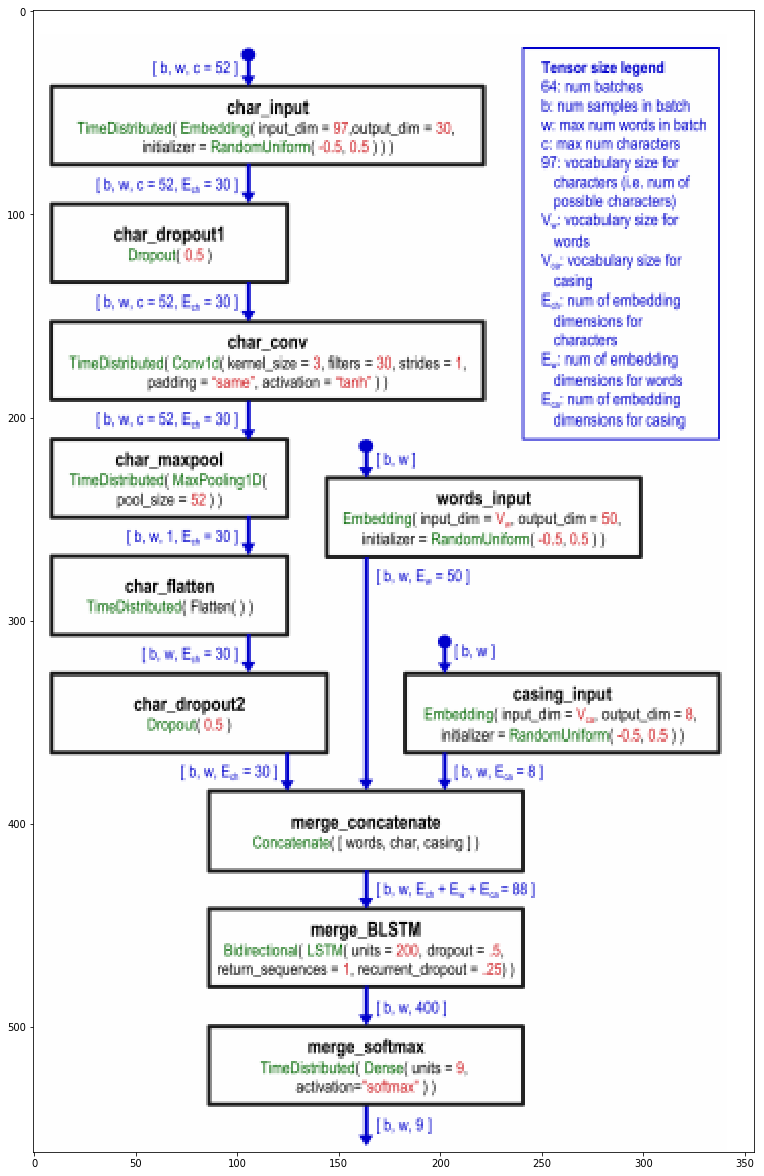

Model built. Saved model.png



In [52]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.gcf()
fig.set_size_inches(37, 21)
plot_model(self.model, to_file='model.png')
img = mpimg.imread('structure.png')
plt.imshow(img)
plt.show()
print("Model built. Saved model.png\n")

## Training Model

We train 30 epochs, collect F1 scores concurrently.

In [47]:
def iterate_minibatches(dataset, batch_len):
    start = 0
    for i in batch_len:
        tokens = []
        caseing = []
        char = []
        labels = []
        data = dataset[start:i]
        start = i
        for dt in data:
            t, c, ch, l = dt
            l = np.expand_dims(l, -1)
            tokens.append(t)
            caseing.append(c)
            char.append(ch)
            labels.append(l)
        
        yield np.asarray(labels), np.asarray(tokens), np.asarray(caseing), np.asarray(char)
        
def tag_dataset(self, dataset, model):
    """Tag data with numerical values"""
    correctLabels = []
    predLabels = []
    for i, data in enumerate(dataset):
        tokens, casing, char, labels = data
        tokens = np.asarray([tokens])
        casing = np.asarray([casing])
        char = np.asarray([char])
        pred = model.predict([tokens, casing, char], verbose=False)[0]
        pred = pred.argmax(axis=-1)  # Predict the classes
        correctLabels.append(labels)
        predLabels.append(pred)
    return predLabels, correctLabels

def compute_f1(predictions, correct, idx2Label):
    label_pred = []
    for sentence in predictions:
        label_pred.append([idx2Label[element] for element in sentence])

    label_correct = []
    for sentence in correct:
        label_correct.append([idx2Label[element] for element in sentence])

    # print("predictions ", len(label_pred))
    # print("correct labels ", len(label_correct))

    prec = compute_precision(label_pred, label_correct)
    rec = compute_precision(label_correct, label_pred)

    f1 = 0
    if (rec + prec) > 0:
        f1 = 2.0 * prec * rec / (prec + rec);

    return prec, rec, f1

def compute_precision(guessed_sentences, correct_sentences):
    assert (len(guessed_sentences) == len(correct_sentences))
    correctCount = 0
    count = 0

    for sentenceIdx in range(len(guessed_sentences)):
        guessed = guessed_sentences[sentenceIdx]
        correct = correct_sentences[sentenceIdx]
        assert (len(guessed) == len(correct))
        idx = 0
        while idx < len(guessed):
            if guessed[idx][0] == 'I':  # a new chunk starts
                count += 1
                #print(guessed[idx]+" ......"+correct[idx])
                if guessed[idx] == correct[idx]:  # first prediction correct
                    idx += 1
                    correctlyFound = True

                    while idx < len(guessed) and guessed[idx][0] == 'I':  # scan entire chunk
                        
                        if guessed[idx] != correct[idx]:
                            
                            correctlyFound = False 

                        idx += 1

                    if idx < len(guessed):
                        if correct[idx][0] == 'I':  # chunk in correct was longer
                            correctlyFound = False

                    if correctlyFound:
                        correctCount += 1
                else:
                    
                    idx += 1
            else:
                idx += 1

    precision = 0
    if count > 0:
        precision = float(correctCount) / count
    return precision

CNN_BLSTM.tag_dataset = tag_dataset

def train(self, model):
    f1_test_history = []
    f1_dev_history = []
    for epoch in range(self.epochs):    
        print("Epoch {}/{}".format(epoch, self.epochs))
        for i,batch in enumerate(iterate_minibatches(self.train_batch,self.train_batch_len)):
            labels, tokens, casing,char = batch       
            model.train_on_batch([tokens, casing,char], labels)

        # compute F1 scores
        predLabels, correctLabels = self.tag_dataset(self.test_batch, model)
        pre_test, rec_test, f1_test = compute_f1(predLabels, correctLabels, self.idx2Label)
        f1_test_history.append(f1_test)
        print("f1 test ", round(f1_test, 4))

        predLabels, correctLabels = self.tag_dataset(self.dev_batch, model)
        pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, self.idx2Label)
        f1_dev_history.append(f1_dev)
        print("f1 dev ", round(f1_dev, 4), "\n")

    print("Final F1 test score: ", f1_test)

    print("Training finished.")
    return f1_test_history, f1_dev_history
CNN_BLSTM.train = train

We train our model on the NER trainset with size 14041 sentences.

In [48]:
self.f1_test_history_LSTM, self.f1_dev_history_LSTM = self.train(self.modelLSTM)

Epoch 0/30
f1 test  0.191
f1 dev  0.1731 

Epoch 1/30
f1 test  0.6899
f1 dev  0.6968 

Epoch 2/30
f1 test  0.7276
f1 dev  0.7209 

Epoch 3/30
f1 test  0.7269
f1 dev  0.7187 

Epoch 4/30
f1 test  0.7349
f1 dev  0.7306 

Epoch 5/30
f1 test  0.7424
f1 dev  0.7413 

Epoch 6/30
f1 test  0.7574
f1 dev  0.7525 

Epoch 7/30
f1 test  0.759
f1 dev  0.765 

Epoch 8/30
f1 test  0.7363
f1 dev  0.7436 

Epoch 9/30
f1 test  0.744
f1 dev  0.7512 

Epoch 10/30
f1 test  0.7629
f1 dev  0.7839 

Epoch 11/30
f1 test  0.7652
f1 dev  0.782 

Epoch 12/30
f1 test  0.7653
f1 dev  0.7827 

Epoch 13/30
f1 test  0.7656
f1 dev  0.7882 

Epoch 14/30
f1 test  0.7647
f1 dev  0.7872 

Epoch 15/30
f1 test  0.7656
f1 dev  0.7898 

Epoch 16/30
f1 test  0.7782
f1 dev  0.8102 

Epoch 17/30
f1 test  0.7739
f1 dev  0.7995 

Epoch 18/30
f1 test  0.7853
f1 dev  0.8075 

Epoch 19/30
f1 test  0.7942
f1 dev  0.8177 

Epoch 20/30
f1 test  0.7763
f1 dev  0.801 

Epoch 21/30
f1 test  0.7911
f1 dev  0.8198 

Epoch 22/30
f1 test  0.783

In [51]:
self.f1_test_history, self.f1_dev_history = self.train(self.model)

Epoch 0/30
f1 test  0.639
f1 dev  0.634 

Epoch 1/30
f1 test  0.7114
f1 dev  0.7224 

Epoch 2/30
f1 test  0.7337
f1 dev  0.7419 

Epoch 3/30
f1 test  0.7665
f1 dev  0.7843 

Epoch 4/30
f1 test  0.7719
f1 dev  0.8065 

Epoch 5/30
f1 test  0.7773
f1 dev  0.8077 

Epoch 6/30
f1 test  0.8045
f1 dev  0.8257 

Epoch 7/30
f1 test  0.7975
f1 dev  0.8241 

Epoch 8/30
f1 test  0.8064
f1 dev  0.8324 

Epoch 9/30
f1 test  0.8026
f1 dev  0.8319 

Epoch 10/30
f1 test  0.8165
f1 dev  0.8543 

Epoch 11/30
f1 test  0.7993
f1 dev  0.8327 

Epoch 12/30
f1 test  0.8295
f1 dev  0.8656 

Epoch 13/30
f1 test  0.8254
f1 dev  0.8611 

Epoch 14/30
f1 test  0.8209
f1 dev  0.8531 

Epoch 15/30
f1 test  0.8256
f1 dev  0.8759 

Epoch 16/30
f1 test  0.8384
f1 dev  0.8714 

Epoch 17/30
f1 test  0.8388
f1 dev  0.88 

Epoch 18/30
f1 test  0.8445
f1 dev  0.8854 

Epoch 19/30
f1 test  0.8387
f1 dev  0.8826 

Epoch 20/30
f1 test  0.8467
f1 dev  0.8872 

Epoch 21/30
f1 test  0.8533
f1 dev  0.8913 

Epoch 22/30
f1 test  0.8

The LSTM model has 0.79 F1 score, the BLSTM model reach 0.85 F1 score.

In [44]:
# save model
self.modelName = "{}_{}_{}_{}_{}_{}_{}".format(self.epochs, 
                                                self.dropout, 
                                                self.dropout_recurrent, 
                                                self.lstm_state_size,
                                                self.conv_size,
                                                self.learning_rate,
                                                self.optimizer.__class__.__name__
                                               )

modelName = self.modelName + ".h5"
self.model.save(modelName)
print("Model weights saved.")

self.model.set_weights(self.init_weights)  # clear model
print("Model weights cleared.")

Model weights saved.
Model weights cleared.


In [45]:
# save model
self.modelNameLSTM = "{}_{}_{}_{}_{}_{}_{}_LSTM".format(self.epochs, 
                                                self.dropout, 
                                                self.dropout_recurrent, 
                                                self.lstm_state_size,
                                                self.conv_size,
                                                self.learning_rate,
                                                self.optimizer.__class__.__name__
                                               )

modelNameLSTM = self.modelNameLSTM + ".h5"
self.modelLSTM.save(modelNameLSTM)
print("LSTM Model weights saved.")

self.modelLSTM.set_weights(self.init_weightsLSTM)  # clear model
print("LSTM Model weights cleared.")

LSTM Model weights saved.
LSTM Model weights cleared.


# 5. Model Results

In [62]:
# a sample prediction
predLabels, correctLabels = self.tag_dataset(self.test_batch[100:110], self.model)
predLabels = [self.idx2Label[x[0]] for x in predLabels]
correctLabels = [self.idx2Label[x[0]] for x in correctLabels]
print("predLabels")
print(predLabels)
print("correctLabels")
print(correctLabels)

predLabels
['I-LOC\n', 'B-LOC\n', 'B-LOC\n', 'B-LOC\n', 'I-LOC\n', 'B-LOC\n', 'I-PER\n', 'B-LOC\n', 'B-MISC\n', 'B-MISC\n']
correctLabels
['I-LOC\n', 'O\n', 'O\n', 'O\n', 'I-LOC\n', 'O\n', 'I-LOC\n', 'O\n', 'O\n', 'O\n']


## Shall we accept the results?
We use f1 score to evaluate the model. We can see that the model reach a 85% F1-score on testset(low false positives and low false negatives). As we split the dataset into three parts (trainset, development set, testset). We could say that the results on testset is reliable, so the performance of BLSTM+CNN is good.

In [39]:
def writeToFile(self):
    """Write output to file"""

    # .txt file format
    # [epoch  ]
    # [f1_test]
    # [f1_dev ]

    output = np.matrix([[int(i) for i in range(self.epochs)], self.f1_test_history, self.f1_dev_history])

    fileName = self.modelName + ".txt"
    with open(fileName,'wb') as f:
        for line in output:
            np.savetxt(f, line, fmt='%.5f')
            print(line)

    print("Model performance written to file.")

CNN_BLSTM.writeToFile = writeToFile
self.writeToFile()

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]]
[[0.47268544 0.6371039  0.68963012 0.7182799  0.73589157 0.71844107
  0.75494378 0.76645869 0.78561965 0.79008524 0.79299609 0.79742328
  0.81072501 0.81114695 0.82122092 0.8084953  0.8216738  0.8290347
  0.81674619 0.83746829 0.83148658 0.83301593 0.81919721 0.83456923
  0.82726286 0.83991516 0.83506074 0.85287754 0.8435565  0.83696071]]
[[0.46785762 0.64634293 0.68818001 0.72107004 0.76305263 0.73253103
  0.76032113 0.77199597 0.80233896 0.82365662 0.81901212 0.82780113
  0.84766776 0.83892075 0.84556882 0.82817814 0.84835442 0.8511912
  0.84591836 0.86841254 0.85819993 0.87285797 0.85384943 0.87074726
  0.86082469 0.87337022 0.86956692 0.88910343 0.87951772 0.88145146]]
Model performance written to file.


## How well did the model perform

When running the code on our local machine, we achieve an F1 score of ~85% with only 30 epochs and around 1 hour of training with the above dropout, LSTM state size, convolutional width and optimiser parameters (see image below). Compared to LSTM, BLSTM converges faster and reach a higher F1 score.

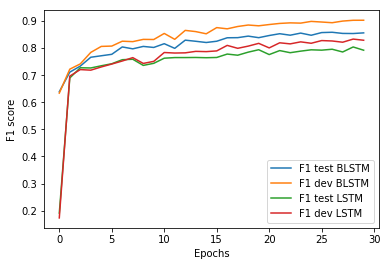

In [53]:
plt.plot(self.f1_test_history, label = "F1 test BLSTM")
plt.plot(self.f1_dev_history, label = "F1 dev BLSTM")
plt.plot(self.f1_test_history_LSTM, label = "F1 test LSTM")
plt.plot(self.f1_dev_history_LSTM, label = "F1 dev LSTM")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

## Analysis of model output

In [41]:
category_count = {"B-ORG\n": 0, "I-ORG\n":0, "B-MISC\n": 0, "I-MISC\n":0, "B-LOC\n": 0, "I-LOC\n": 0, "B-PER\n": 0, "I-PER\n": 0, "O\n": 0}
total_count = 0

for sentence in self.trainSentences:
    for word in sentence:
        if word[2] in category_count.keys():
            category_count[word[2]] += 1
            total_count += 1

for category, count in category_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count/total_count)*100, 2)))   

B-ORG: 0.01%
I-ORG: 4.91%
B-MISC: 0.02%
I-MISC: 2.24%
B-LOC: 0.01%
I-LOC: 4.07%
B-PER: 0.0%
I-PER: 5.47%
O: 83.28%


## Possible Source of Error
1. We only use 30 epochs instead of 80 epochs, we might not reach the best optimization
2. We did not gird search the hyper parameters (hyper-parameter choice is likely sensitive to the type of word embeddings used, optimizing them all will likely produce better results and provide a fairer comparison of word embedding quality)
3. Application of existing lexicons is not flexible.

# 6. Conclusion
In this work, we use Bidirectional LSTM + CNN model to solve the name entity recogonition problem (tagging entities in text with their corresponding type). We use the Reuters News Corpus Dataset to test our model. In 1-hour training, we achieve an F1 score of ~85% within 30 epochs.To conclude, compared to LSTM, bidirectional LSTMs are a very powerful and flexible type of neural network for named entity recognition. 

## Futurework
We may try more effective construction and application of lexicons and word embeddings in the future.
